In [1]:
#import libraries needed for all three questions 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
#import calendar data from csv files
sea_calendar = pd.read_csv('seattle_calendar.csv')
sea_listings = pd.read_csv('seattle_listings.csv')

In [10]:
###QUESTION 1: What are the busiest times of the year to visit Seattle? How much price spike?

#change data type for manipulation for 'date' and 'price'
sea_calendar['date']=pd.to_datetime(sea_calendar['date'])
sea_calendar['price']=sea_calendar['price'].str.extract('([0-9.]+)')
sea_calendar['price']=pd.to_numeric(sea_calendar['price'])

#create a column for 'month' so that average price by month can be calcualted
sea_calendar['month']=pd.DatetimeIndex(sea_calendar['date']).month

In [4]:
#calcualte the price per person for further analysis later
sea_price = pd.merge(sea_calendar,sea_listings[['accommodates','id']],left_on='listing_id',right_on='id')
sea_price['price per person'] = sea_price['price']/sea_price['accommodates']

#calculate the monthly average price and monthly avearge price per person for each listing
#the average for each listing is calcualted based on available data, assuming price is the same for unavailable dates
sea_price_by_id_month = sea_price.groupby(['listing_id','month']).mean()[['price','price per person']]
sea_price_by_month = sea_price_by_id_month.groupby(['month']).mean()[['price','price per person']]

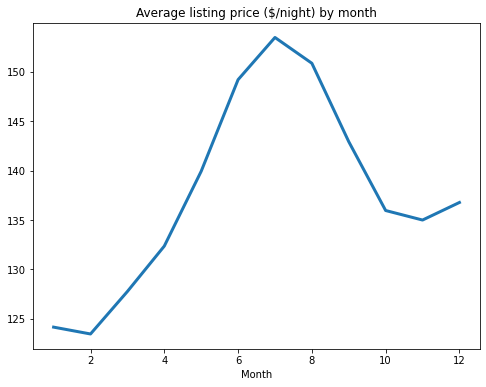

In [5]:
#visualize the price trend by months
#there may be also the time element impact -- booking a place a few months into the future may be more pricy/cheaper

plt.figure(figsize=(8,6))
plt.plot(list(sea_price_by_month.index),list(sea_price_by_month['price']),linewidth=3)
plt.title('Average listing price ($/night) by month')
plt.gca().set_xlabel('Month')
plt.show()

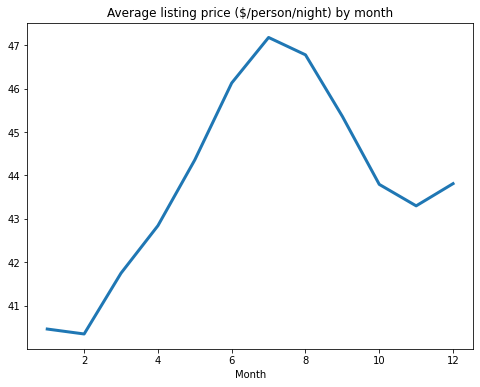

In [83]:
#visualize the price per person trend by months
#there may be also the time element impact -- booking a place a few months into the future may be more pricy/cheaper

plt.figure(figsize=(8,6))
plt.plot(list(sea_price_by_month.index),list(sea_price_by_month['price per person']),linewidth=3)
plt.title('Average listing price ($/person/night) by month')
plt.gca().set_xlabel('Month')
plt.show()

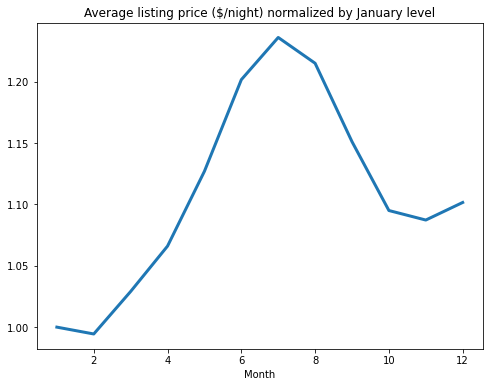

In [85]:
#visualize the normalized price trend by months
#there may be also the time element impact -- booking a place a few months into the future may be more pricy/cheaper

plt.figure(figsize=(8,6))
plt.plot(list(sea_price_by_month.index),list(sea_price_by_month['price']/sea_price_by_month.iloc[0]['price']),linewidth=3)
plt.title('Average listing price ($/night) normalized by January level')
plt.gca().set_xlabel('Month')
plt.show()

In [3]:
###QUESTION 2: What is the vibe for some of the popular neighbourhood based on listing description?

#remove rows with nan in neighborhood_overview or neighbourhood
#group by neighbourhood, then create a list for all descriptions for each neighbourhood
sea_nbr_description = sea_listings.dropna(subset=['neighbourhood','neighborhood_overview'],axis=0).groupby('neighbourhood')['neighborhood_overview'].apply(''.join)

#text is a list of neighbourhood description for one neighbourhood
text =list(sea_nbr_description)


In [12]:
#analyse the topic distribution of the neighbourhood description using LDA model

# Use CountVectorizor to find three letter tokens, remove stop_words 
# remove tokens that don't appear in at least 5 descriptions or appear in >50% of the documents
vect = CountVectorizer(min_df=5, max_df=0.5,stop_words='english', token_pattern='(?u)\\b\\w\\w\\w+\\b')
X = vect.fit_transform(text)
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())
ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=3,id2word=id_map,passes=25,random_state=1)
topic = ldamodel.get_document_topics(corpus)

In [21]:
#look at the key words in the three topics and name the topics accordingly
ldamodel.print_topics(num_topics=3, num_words=12)
## 0 - nature scenery/suburb
## 1 - tourist attractions
## 2 - city life

[(0,
  '0.020*"ballard" + 0.017*"fremont" + 0.009*"trail" + 0.008*"green" + 0.007*"wallingford" + 0.007*"zoo" + 0.006*"greenlake" + 0.006*"woodland" + 0.006*"columbia" + 0.005*"gardens" + 0.005*"burke" + 0.005*"alki"'),
 (1,
  '0.015*"art" + 0.015*"capitol" + 0.013*"museum" + 0.012*"madison" + 0.012*"needle" + 0.011*"music" + 0.010*"central" + 0.010*"belltown" + 0.008*"experience" + 0.008*"heart" + 0.008*"score" + 0.007*"madrona"'),
 (2,
  '0.028*"capitol" + 0.024*"queen" + 0.024*"anne" + 0.009*"needle" + 0.008*"nightlife" + 0.008*"museum" + 0.007*"union" + 0.007*"art" + 0.007*"apartment" + 0.007*"volunteer" + 0.007*"pine" + 0.007*"broadway"')]

In [22]:
#create dictionaries containing neighbourhoods with >60 reviews (only focus on those more "popular" neighbourhoods)
#find the "top" topic for each of the neighbourhood -- the topic must have a topic percent >50% (must be the highest)

#top_topic dictionary: {neighbourhood: the top topic in the description about this neighbourhood}
#top_percent dictionary: {neighbourhood: the percent% of the top topic in the description about this neighbourhood}
top_topic = dict()
top_percent = dict()
iter = 0
for element in topic:
    if len(sea_listings[sea_listings['neighbourhood']==sea_nbr_description.index[iter]])>60:
        top_topic[sea_nbr_description.index[iter]] = [k for k,v in element if v>0.5][0]
        top_percent[sea_nbr_description.index[iter]] = [v for k,v in element if v>0.5][0]
    iter+=1

#create a dataframe for ease of data analysis
sea_nbr_vibe = pd.DataFrame([top_topic,top_percent]).T
sea_nbr_vibe.columns=['topic','topic_percent']
sea_nbr_vibe = sea_nbr_vibe.reset_index()
sea_nbr_vibe['topic'].replace({0.0:'nature scenery/suburb',1.0:'tourist attractions',2.0:'city life'}, inplace=True)
sea_nbr_vibe.sort_values('topic')


,index,topic,topic_percent
2,Capitol Hill,city life,0.999115
5,First Hill,city life,0.978029
8,Lower Queen Anne,city life,0.998977
11,Queen Anne,city life,0.842948
12,Stevens,city life,0.878138
0,Ballard,nature scenery/suburb,0.988220
4,Columbia City,nature scenery/suburb,0.914091
6,Fremont,nature scenery/suburb,0.984148
7,Greenwood,nature scenery/suburb,0.972283
10,North Beacon Hill,nature scenery/suburb,0.852995


In [20]:
#look at what neighbourhoods are included in each of the topics
topic_dist = sea_nbr_vibe.groupby('topic')['index'].apply(list)
#neighbourhood vibe: nature scenery 
print(topic_dist[0])

#neighbourhood vibe: tourist attractions 
print(topic_dist[1])

#neighbourhood vibe: city life 
print(topic_dist[2])

['Capitol Hill', 'First Hill', 'Lower Queen Anne', 'Queen Anne', 'Stevens']
['Ballard', 'Columbia City', 'Fremont', 'Greenwood', 'North Beacon Hill', 'University District', 'Wallingford']
['Belltown', 'Central Business District', 'Minor']


In [40]:
#Additional analysis: the tfidf for each neighbourhood 

#use TfidfVectorizer to calculate the Tfidf for tokens and identify the key words for each neighbourhood
vect_2 = TfidfVectorizer(min_df=10, max_df=0.6, stop_words='english', token_pattern='(?u)\\b\\w\\w\\w+\\b')
X_2 = vect_2.fit_transform(text)
feature_names = vect_2.get_feature_names()

#X contains the tfidf for each neighbourhood/token pairs, convert to array and sort to find the highest tfidf
tfidf_ind = np.argsort(X_2.toarray(),axis=1)

sea_nbr_word = dict()
for n in range(len(sea_nbr_description)):
    #only analysing neighbourhood that has >60 listings (otherwise description may not be representative)
    if len(sea_listings[sea_listings['neighbourhood']==sea_nbr_description.index[n]])>60:
        sea_nbr_word[sea_nbr_description.index[n]] = [feature_names[i] for i in tfidf_ind[n,-5:] if feature_names[i] not in sea_nbr_description.index[n].lower().split()]

#look at the top 5 words with high tfidf, this is in agreement with the topic identified with LDA model
sea_nbr_word

{'Ballard': ['farmers', 'gardens', 'locks', 'golden'],
 'Belltown': ['museum', 'project', 'needle', 'pike'],
 'Capitol Hill': ['best', 'nightlife', 'pike', 'pine'],
 'Central Business District': ['art', 'needle', 'project', 'museum', 'pike'],
 'Columbia City': ['music', 'theater', 'rail', 'diverse'],
 'First Hill': ['theaters', 'art', 'culture', 'capitol', 'pike'],
 'Fremont': ['gilman', 'woodland', 'zoo', 'burke'],
 'Greenwood': ['golden', 'green', 'greenlake', 'phinney'],
 'Lower Queen Anne': ['museum', 'needle', 'theater'],
 'Minor': ['art', 'valley', 'central', 'capitol', 'madison'],
 'North Beacon Hill': ['station', 'ave', 'light', 'golf', 'rail'],
 'Queen Anne': ['views', 'needle', 'fremont'],
 'Stevens': ['best', 'nightlife', 'pine', 'drink', 'capitol'],
 'University District': ['activities', 'score', '100', 'array'],
 'Wallingford': ['woodland', 'green', 'greenlake', 'fremont']}

In [4]:
###QUESTION 3: How should a host set rental price based on rental listing info? 
###QUESTION 4: what are the key features that influence the rental listing price?

#train a machine learning model to predict the price based on features, and rank feature importance
#select features 
cat_cols = ['host_is_superhost','host_identity_verified','zipcode',
               'neighbourhood_group_cleansed','property_type','room_type','instant_bookable','cancellation_policy']

num_cols = ['accommodates','bathrooms','bedrooms','beds',
              'cleaning_fee','minimum_nights','latitude','longitude','number_of_reviews','review_scores_rating','reviews_per_month']

select_cols = cat_cols + num_cols + ['price']
df_listing = sea_listings[select_cols]

#review the data availability -- missing data in some columns
print(df_listing.count().sort_values())


cleaning_fee                    2788
review_scores_rating            3171
reviews_per_month               3191
bathrooms                       3802
zipcode                         3811
bedrooms                        3812
host_is_superhost               3816
host_identity_verified          3816
property_type                   3817
beds                            3817
cancellation_policy             3818
accommodates                    3818
room_type                       3818
neighbourhood_group_cleansed    3818
minimum_nights                  3818
latitude                        3818
longitude                       3818
number_of_reviews               3818
instant_bookable                3818
price                           3818
dtype: int64


In [5]:
import warnings
warnings.filterwarnings("ignore")

#cleaning_fee -- fill NAN with 0, assuming "NAN" means no cleaning fee required
#need to change data type for 'price' and 'cleaning_fee', extract numbers and convert to float
df_listing['cleaning_fee']=df_listing['cleaning_fee'].str.extract('([0-9.]+)')
df_listing['cleaning_fee']=pd.to_numeric(df_listing['cleaning_fee'])
df_listing['cleaning_fee']=df_listing['cleaning_fee'].fillna(0)
df_listing['price']=df_listing['price'].str.extract('([0-9.]+)')
df_listing['price']=pd.to_numeric(df_listing['price'])

#reviews_per_month -- fill NAN with 0, assuming "NAN" means no review yet
df_listing['reviews_per_month']=df_listing['reviews_per_month'].fillna(0)

#add a column of "review_unavailable" -- if "review_scores_rating" is NAN, assign True, else False
df_listing['review_unavailable'] = df_listing['review_scores_rating'].isnull().apply(lambda x:'t' if x is True else 'f')

#review_scores_rating -- fill NAN with mean value of dataset, assuming impact of this feature is "neutral" for those
df_listing['review_scores_rating']=df_listing['review_scores_rating'].fillna(df_listing['review_scores_rating'].mean())
          
#other columns only have <2 missing values, drop NAN row directly (impact is small)
df_listing.dropna(inplace=True)


In [6]:
#confirm number of data points available & no NAN for any features
print(df_listing.count().sort_values())

host_is_superhost               3786
reviews_per_month               3786
review_scores_rating            3786
number_of_reviews               3786
longitude                       3786
latitude                        3786
minimum_nights                  3786
cleaning_fee                    3786
beds                            3786
price                           3786
bedrooms                        3786
accommodates                    3786
cancellation_policy             3786
instant_bookable                3786
room_type                       3786
property_type                   3786
neighbourhood_group_cleansed    3786
zipcode                         3786
host_identity_verified          3786
bathrooms                       3786
review_unavailable              3786
dtype: int64


In [7]:
cat_cols = cat_cols + ['review_unavailable']
X_cat = pd.get_dummies(df_listing[cat_cols],drop_first=True)
X = df_listing[num_cols].merge(X_cat,left_index=True,right_index=True)
y = df_listing['price']

In [8]:
##Randomforest regressor
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

regressor = RandomForestRegressor(n_estimators=100, max_depth=10,random_state=1).fit(X_train,y_train)
print(regressor.score(X_train,y_train))
print(regressor.score(X_test,y_test))


0.8772871412286325
0.6672692255355055


<Figure size 432x288 with 0 Axes>

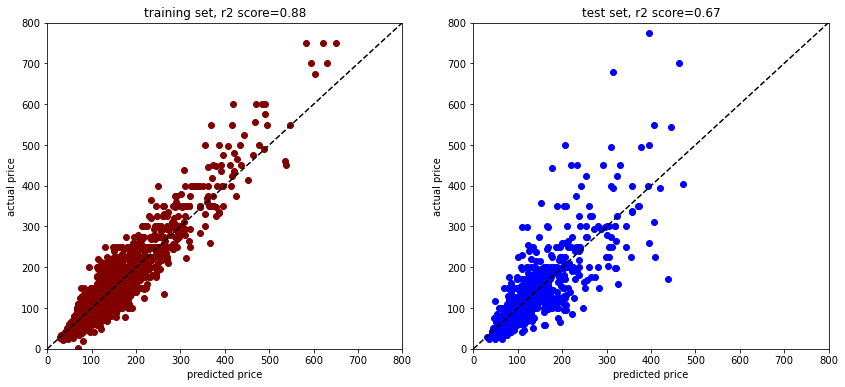

In [9]:
# look at the model accuracy for training set and test set
# the model overfits as the training score is higher than the test score
pred_test = regressor.predict(X_test)
pred_train = regressor.predict(X_train)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6))
ax1.scatter(pred_train,y_train,color='maroon')
ax1.plot([0,800],[0,800],linestyle='dashed', color='black')
ax1.set_xlim([0,800])
ax1.set_ylim([0,800])
ax1.title.set_text('training set, r2 score=0.88')
ax1.set_xlabel('predicted price')
ax1.set_ylabel('actual price')


ax2.scatter(pred_test,y_test,color='blue')
ax2.plot([0,800],[0,800],linestyle='dashed', color='black')
ax2.set_xlim([0,800])
ax2.set_ylim([0,800])
ax2.title.set_text('test set, r2 score=0.67')
ax2.set_xlabel('predicted price')
ax2.set_ylabel('actual price')

plt.show()

In [15]:
#identify important features 
feature_rank = pd.DataFrame([X.columns,regressor.feature_importances_]).T
feature_rank.columns=['feature','importance']
feature_rank.sort_values('importance',ascending=False).head(10)
#apparently, number of bedrooms, how many people it accommodates are the two most important features for a listing
#cleaning fee amount, number of bathrooms, locations (lat,lon) are also important

,feature,importance
2,bedrooms,0.41232
0,accommodates,0.082018
4,cleaning_fee,0.076381
1,bathrooms,0.064571
6,latitude,0.051849
7,longitude,0.037836
71,room_type_Private room,0.031952
10,reviews_per_month,0.031009
8,number_of_reviews,0.0279
45,neighbourhood_group_cleansed_Downtown,0.019585


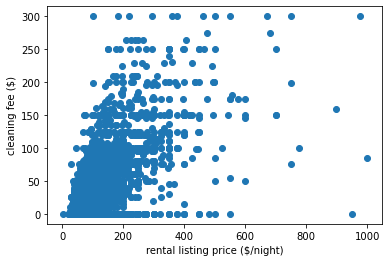

In [17]:
#look at the correlation between cleaning fee and rental listing price
#probably only reasonable to charge high cleaning fee if the rental price itself is high. 
#Also cleaning a nicer house could potentially cost more.

plt.figure()
plt.scatter(y,X['cleaning_fee'])
plt.xlabel('rental listing price ($/night)')
plt.ylabel('cleaning fee ($)')
plt.show()